# Breast Cancer Wisconsin Classification: End-to-End ML Project

**Goal**: Predict whether a tumor is **malignant** or **benign** based on cell nuclei features.

This notebook covers:
- Exploratory Data Analysis (EDA)
- Feature insights and visualization
- Multiple model training and comparison
- Evaluation with comprehensive metrics
- Final model selection for deployment

Final model will be saved and used in FastAPI + Docker + Kubernetes pipeline.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [15]:
# Load dataset
data = load_breast_cancer()

# Create DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (569, 32)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,malignant


In [16]:
print("Class Distribution:")
print(df['diagnosis'].value_counts())
print("\nPercentage:")
print(df['diagnosis'].value_counts(normalize=True) * 100)

df.info()
df.describe()

Class Distribution:
diagnosis
benign       357
malignant    212
Name: count, dtype: int64

Percentage:
diagnosis
benign       62.741652
malignant    37.258348
Name: proportion, dtype: float64
<class 'pandas.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


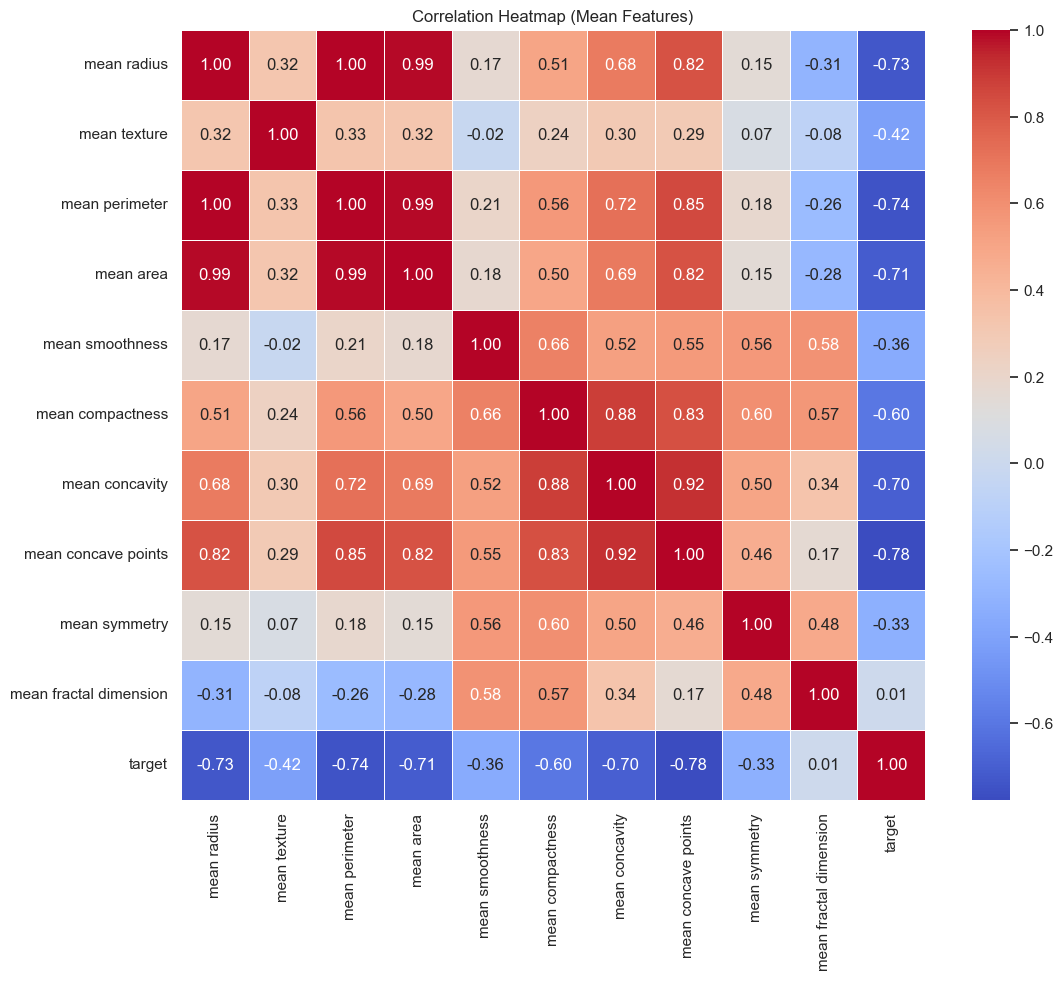

In [17]:
# Correlation matrix for mean features (top 10 most correlated with target)
mean_cols = [col for col in df.columns if 'mean' in col]
corr = df[mean_cols + ['target']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap (Mean Features)")
plt.show()

In [18]:
# Top 10 features most correlated with target
corr_with_target = df.drop(columns=['diagnosis']).corr()['target'].abs().sort_values(ascending=False)
print("Top 10 features correlated with target:")
print(corr_with_target[1:11])  # excluding target itself

Top 10 features correlated with target:
worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
Name: target, dtype: float64



Visualizing distributions for top 5 features:
['worst concave points', 'worst perimeter', 'mean concave points', 'worst radius', 'mean perimeter']


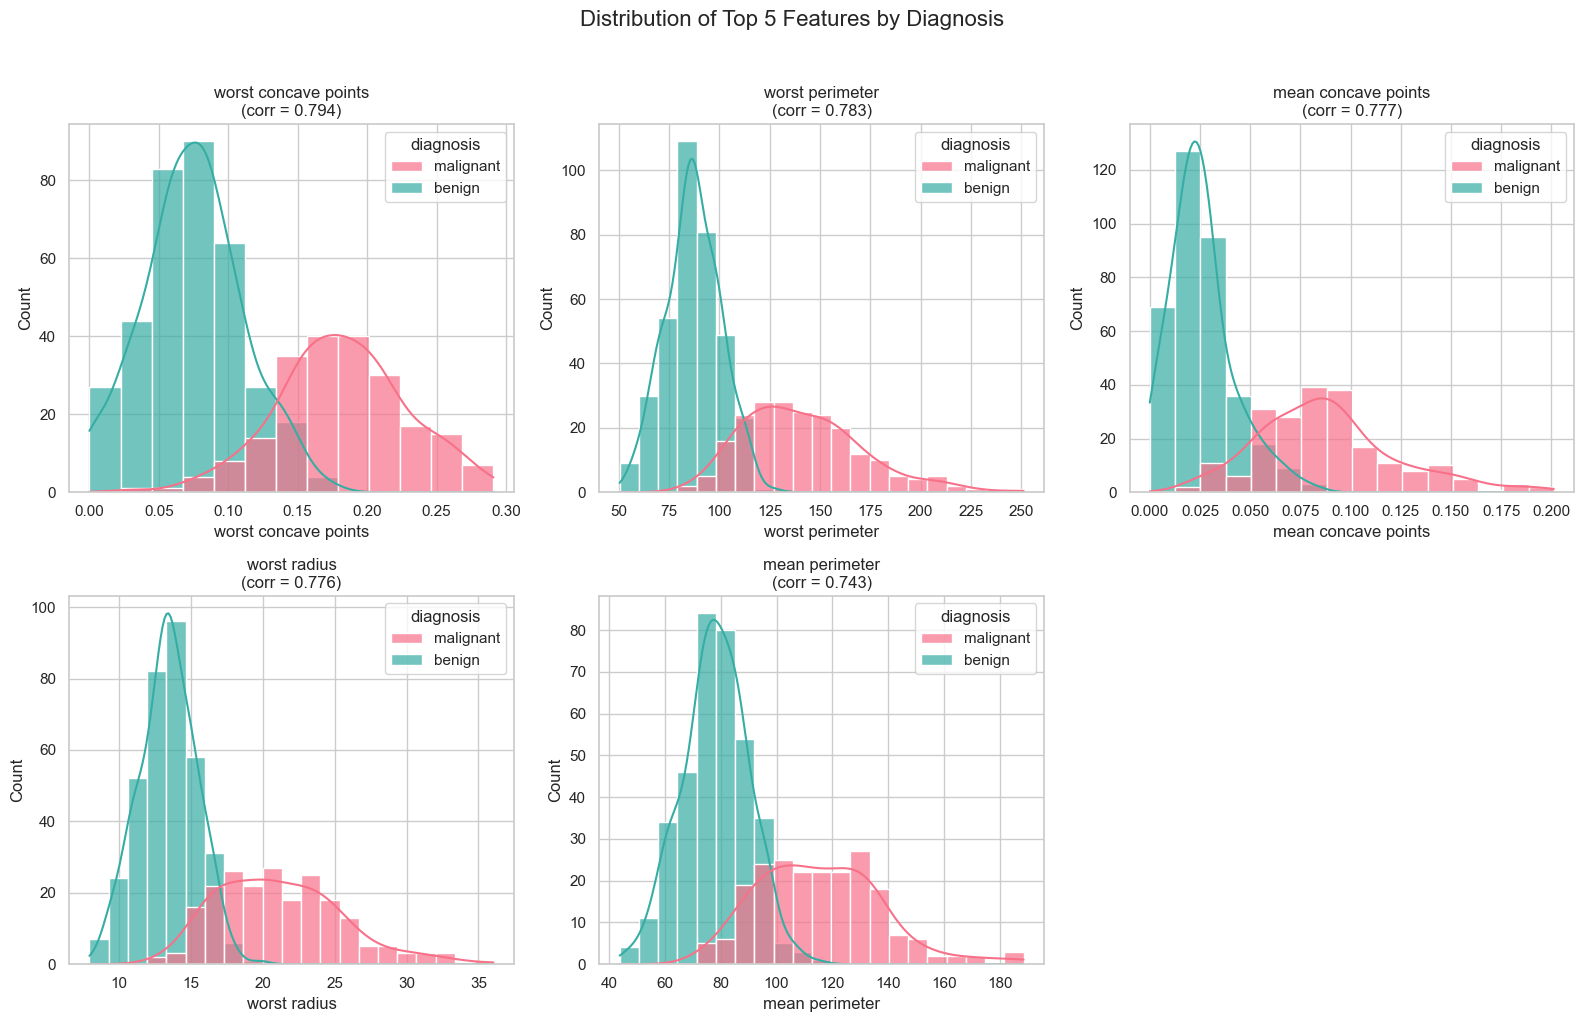

In [20]:
# Select top 5 features
top_5_features = corr_with_target[1:6].index.tolist()
print("\nVisualizing distributions for top 5 features:")
print(top_5_features)

# Plot histograms with KDE
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, feature in enumerate(top_5_features):
    sns.histplot(data=df, x=feature, hue='diagnosis', kde=True, ax=axes[i], palette='husl', alpha=0.7)
    axes[i].set_title(f'{feature}\n(corr = {corr_with_target[feature]:.3f})', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Hide the empty 6th subplot
axes[5].set_visible(False)

plt.suptitle('Distribution of Top 5 Features by Diagnosis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

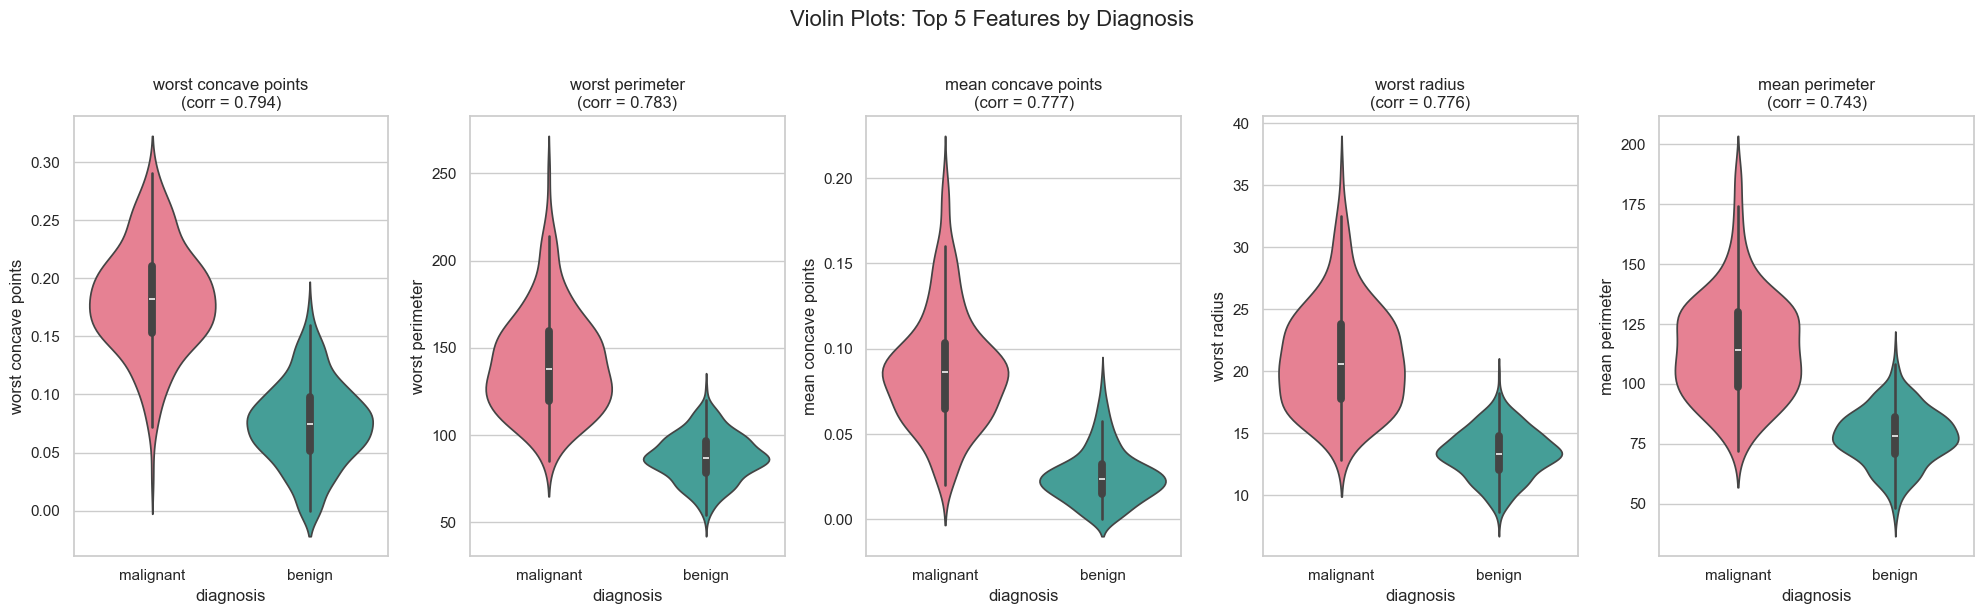

In [21]:
# Violin plots for top 5 features (shows distribution shape + quartiles)
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
for i, feature in enumerate(top_5_features):
    sns.violinplot(data=df, x='diagnosis', y=feature, ax=axes[i], palette='husl')
    axes[i].set_title(f'{feature}\n(corr = {corr_with_target[feature]:.3f})')

plt.suptitle('Violin Plots: Top 5 Features by Diagnosis', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

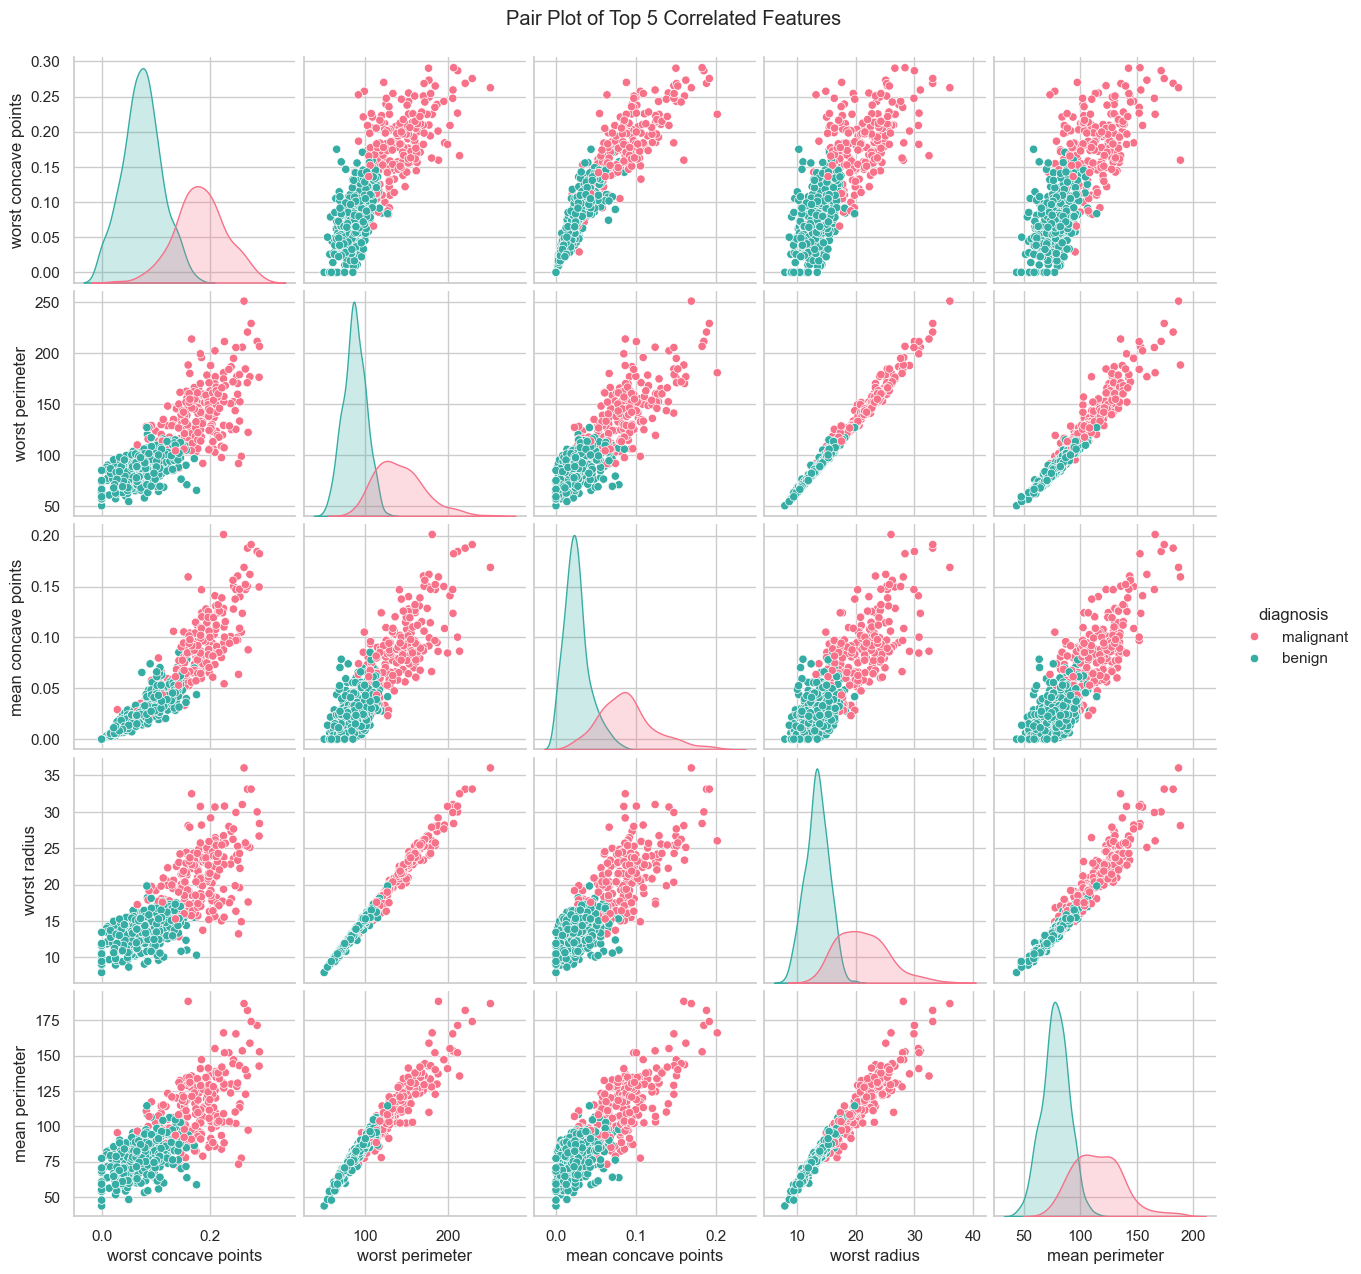

In [22]:
# Pairplot of top 5 features + diagnosis
top_features = corr_with_target[1:6].index.tolist()
sns.pairplot(df[top_features + ['diagnosis']], hue='diagnosis', palette='husl', diag_kind='kde')
plt.suptitle('Pair Plot of Top 5 Correlated Features', y=1.02)
plt.show()

In [23]:
X = df.drop(['target', 'diagnosis'], axis=1)
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (important for Logistic Regression, SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 455
Test samples: 114


In [24]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss')
}

results = []

for name, model in models.items():
    # Use scaled data for LR and SVM, raw for tree-based
    if name in ["Logistic Regression", "SVM"]:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    })

results_df = pd.DataFrame(results).round(4)
results_df = results_df.sort_values('F1', ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.9825,0.9861,0.9861,0.9861,0.9954
3,SVM,0.9825,0.9861,0.9861,0.9861,0.9950
4,XGBoost,0.9561,0.9467,0.9861,0.9660,0.9901
2,Random Forest,0.9561,0.9589,0.9722,0.9655,0.9937
1,Decision Tree,0.9123,0.9559,0.9028,0.9286,0.9157


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        scores = cross_val_score(model, scaler.transform(X), y, cv=cv, scoring='f1')
    else:
        scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    cv_scores[name] = scores.mean()

print("5-Fold CV F1 Scores:")
for name, score in sorted(cv_scores.items(), key=lambda x: -x[1]):
    print(f"{name}: {score:.4f}")

5-Fold CV F1 Scores:
SVM: 0.9805
Logistic Regression: 0.9794
Random Forest: 0.9651
XGBoost: 0.9622
Decision Tree: 0.9299


FINAL MODEL SELECTION
Based on the results:
- SVM and Logistic Regression both achieve 98.25% accuracy and 98.61% F1
- SVM has the highest 5-fold CV F1 score: 0.9805 → most stable
- Excellent ROC AUC (~0.995) indicates outstanding discrimination
- In medical diagnosis, we prioritize high recall for malignant class (minimize false negatives)

→ Choosing SVM as the final production model for superior stability and performance

Final Model: Support Vector Machine (SVM)

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



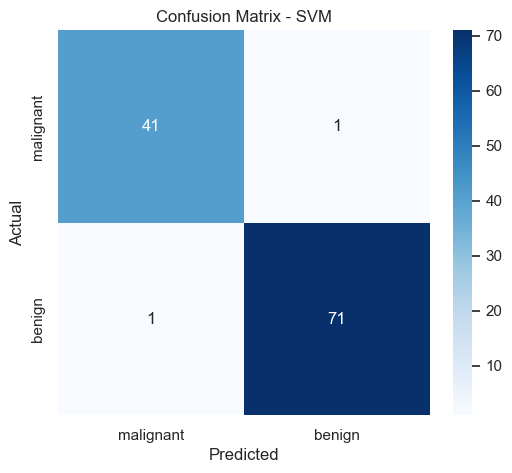

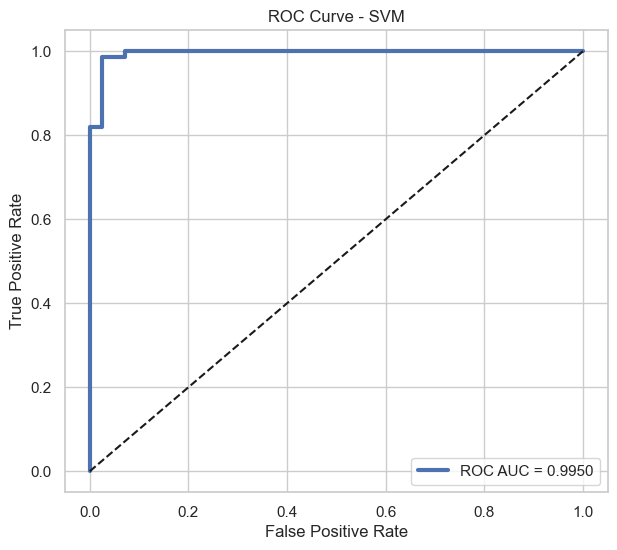

In [26]:
# Final Model Selection Justification
print("="*60)
print("FINAL MODEL SELECTION")
print("="*60)
print("Based on the results:")
print("- SVM and Logistic Regression both achieve 98.25% accuracy and 98.61% F1")
print("- SVM has the highest 5-fold CV F1 score: 0.9805 → most stable")
print("- Excellent ROC AUC (~0.995) indicates outstanding discrimination")
print("- In medical diagnosis, we prioritize high recall for malignant class (minimize false negatives)")
print("\n→ Choosing SVM as the final production model for superior stability and performance")

# Train final SVM model on full training data (with scaling)
final_scaler = StandardScaler()
X_train_scaled = final_scaler.fit_transform(X_train)
X_test_scaled = final_scaler.transform(X_test)

final_model = SVC(probability=True, random_state=42)  # probability=True for predict_proba
final_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

print("\nFinal Model: Support Vector Machine (SVM)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['malignant', 'benign']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['malignant', 'benign'],
            yticklabels=['malignant', 'benign'])
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob):.4f}', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Cell 12: Save Model, Scaler, and Feature Names for Deployment

import joblib
import os

# Define the correct model directory inside the project (safe and reliable)
MODEL_DIR = os.path.join(os.getcwd(), "model")

# Create model directory if not exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Save the trained SVM model
joblib.dump(final_model, os.path.join(MODEL_DIR, "model.joblib"))

# Save the fitted scaler — ABSOLUTELY NECESSARY for consistent inference!
joblib.dump(final_scaler, os.path.join(MODEL_DIR, "scaler.joblib"))

# Save feature names for input validation in API
joblib.dump(data.feature_names.tolist(), os.path.join(MODEL_DIR, "feature_names.joblib"))

print("Deployment artifacts saved successfully!")
print("   → ../model/model.joblib     (SVM model)")
print("   → ../model/scaler.joblib    (Fitted StandardScaler - REQUIRED)")
print("   → ../model/feature_names.joblib")

Deployment artifacts saved successfully!
   → ../model/model.joblib     (SVM model)
   → ../model/scaler.joblib    (Fitted StandardScaler - REQUIRED)
   → ../model/feature_names.joblib
